![alt text](img/LM.png)
# Kurs: Warsztaty Machine learning w Pythonie

## Prowadzący: Piotr Ćwiakowski

## Autorzy: Piotr Ćwiakowski, Maciej Wilamowski

### Lekcja 14. Egzamin

W celu zaliczenia egzaminu należy rozwiązać **jedno** z poniższych zadań. W każdym zadaniu należy wykonać, adekwatnie do analizowanego zbioru:

1) wstępną analizę EDA (*Explonatory Data Analysis*) w celu rozpoznania informacji w zbiorze (możesz zasugerować się wykonanymi w Internecie analizami, przy czym w analizie zbioru tekstowego, obrazów i zwykłych plików płaskich wygląda ona nieco inaczej - najmniej potrzebna jest w przypadku analizy obrazów).  
2) etap **feature engineering**, w którym wytworzymy/przekształcimy/dołączymy nowe zmienne - oczywiście adekwatnie do zadania (najmniej będzie to potrzebne w analizie obrazów).  
3) zbudować jak najlepszy model predykcyjny wykorzystując techniki modelowania poznane na zajęciach oraz walidację krzyżową.

Rozwiązanie należy przesłać w dowolnym terminie na adres <pcwiakowski@labmasters.pl> i umówić się z prowadzącym na krótkie spotkanie (do 15 minut), na którym zostanie omówione (w swobodnej dyskusji) rozwiązane zaproponowane przez uczestnika.

W razie pytań zapraszam do kontaktu na podany powyżej adres email.

<center><h3>Powodzenia! </h3></center>

# Zadanie 3.

Wykonaj sieć neuronową (wykorzystując architektury MLP, CNN), w której stworzysz model klasyfikujący czy na zdjęciu pojawia się Obcy (istota z serii filmów sf zapoczątkowanej filmej Ridleya Scotta *Obcy. Ósmy pasażer Nostromo)* czy Predator (istota z serii zapoczątkowanej udanymi filmami *Predator 1* i *Predator 2*). Twoim zadaniem jest:
- wczytanie danych,
- oflagowanie obserwacji (zmienna objaśniana binarna predator/obcy) dla zbioru treningowego i testowego,
- wytrenowanie odpowiedniej sieci neuronowej na zbiorze treningowym,
- ewaluacja jej na zbiorze testowym.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import math
import datetime
import os
import pathlib
import random
import imageio.v3 as iio
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import multiprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LeakyReLU
import matplotlib
import matplotlib.pyplot as plt
from skimage.filters import roberts, sobel, scharr, prewitt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from IPython.display import display
%matplotlib inline
print('TensorFlow version: ' + tf.__version__)

TensorFlow version: 2.11.1


In [2]:
cwd = os.getcwd()
proj_path = cwd
data_path = cwd + r'/work/alien-vs-predator'
work = pathlib.Path(data_path)
list(work.rglob('*.jpg'))

[PosixPath('/home/jovyan/work/alien-vs-predator/test/alien/91.jpg'),
 PosixPath('/home/jovyan/work/alien-vs-predator/test/alien/92.jpg'),
 PosixPath('/home/jovyan/work/alien-vs-predator/test/alien/93.jpg'),
 PosixPath('/home/jovyan/work/alien-vs-predator/test/alien/94.jpg'),
 PosixPath('/home/jovyan/work/alien-vs-predator/test/alien/95.jpg'),
 PosixPath('/home/jovyan/work/alien-vs-predator/test/alien/96.jpg'),
 PosixPath('/home/jovyan/work/alien-vs-predator/test/alien/97.jpg'),
 PosixPath('/home/jovyan/work/alien-vs-predator/test/alien/98.jpg'),
 PosixPath('/home/jovyan/work/alien-vs-predator/test/alien/99.jpg'),
 PosixPath('/home/jovyan/work/alien-vs-predator/test/predator/91.jpg'),
 PosixPath('/home/jovyan/work/alien-vs-predator/test/predator/92.jpg'),
 PosixPath('/home/jovyan/work/alien-vs-predator/test/predator/93.jpg'),
 PosixPath('/home/jovyan/work/alien-vs-predator/test/predator/94.jpg'),
 PosixPath('/home/jovyan/work/alien-vs-predator/test/predator/95.jpg'),
 PosixPath('/home/j

In [3]:
def listing_files(path, ext):
    paths = pathlib.Path(path)
    files = list(paths.rglob(ext))
    return(files)

In [4]:
cwd = os.getcwd()
path = cwd + r'/work/alien-vs-predator/train'
files = listing_files(path, '*.jpg')


width_list = np.array([])
height_list = np.array([])
files_shuffle = files.copy()
random.shuffle(files_shuffle)
for count, file in enumerate(files_shuffle):
    name = str(file.parent.name)
    dirname = file.parent
    im = iio.imread(file)
    width = im.shape[0]
    height = im.shape[1]
    width_list = np.append(width_list, width)
    height_list = np.append(height_list, height)
    if len(im.shape) < 3:
        color = 'b&w'
    else:
        color = 'color'
        
    pos = str(count)
    w = str(width)
    h = str(height)
    print("{}) {} {}x{} {}".format(pos, name, w, h, color))

0) alien 147x342 color
1) alien 258x196 color
2) alien 275x183 color
3) predator 145x348 color
4) predator 160x315 color
5) predator 180x240 color
6) alien 180x280 color
7) alien 168x300 color
8) alien 168x300 color
9) alien 196x257 color
10) predator 259x194 color
11) alien 267x189 color
12) alien 240x180 color
13) alien 180x200 color
14) alien 175x287 color
15) alien 169x299 color
16) predator 188x268 color
17) predator 163x310 color
18) predator 299x168 color
19) alien 183x276 color
20) alien 178x283 color
21) predator 291x173 color
22) alien 159x318 color
23) alien 225x225 color
24) predator 168x300 color
25) predator 152x331 color
26) alien 188x268 color
27) predator 277x182 color
28) predator 273x184 color
29) predator 275x183 color
30) alien 275x183 color
31) predator 172x293 color
32) predator 168x300 color
33) predator 188x268 color
34) alien 256x197 color
35) predator 168x300 color
36) alien 251x201 color
37) alien 145x348 color
38) alien 170x297 color
39) predator 259x194 co

419) predator 178x284 color
420) alien 173x292 color
421) alien 225x225 color
422) predator 190x265 color
423) predator 253x199 color
424) predator 177x284 color
425) predator 272x186 color
426) alien 168x299 color
427) predator 225x225 color
428) alien 263x192 color
429) predator 146x346 color
430) predator 206x245 color
431) predator 168x300 color
432) alien 223x226 color
433) alien 273x184 color
434) predator 257x196 color
435) predator 168x299 color
436) alien 175x288 color
437) alien 250x202 color
438) alien 170x296 color
439) predator 245x206 color
440) predator 313x161 color
441) alien 251x201 color
442) alien 194x259 color
443) alien 173x291 color
444) predator 225x225 color
445) predator 225x225 color
446) alien 210x93 color
447) predator 168x300 color
448) predator 275x184 color
449) alien 259x194 color
450) predator 253x199 color
451) predator 168x300 color
452) alien 285x177 color
453) alien 185x273 color
454) alien 168x300 color
455) predator 163x309 color
456) alien 290x1

In [5]:
n_image = len(files)
print("Number of elements: {}".format(n_image))
print("Minimum width: {}".format(min(width_list)))
print("Maksimum width: {}".format(max(width_list)))
print("Minimum height: {}".format(min(height_list)))
print("Maksimum height: {}".format(max(height_list)))
width = np.median(width_list)
height = np.median(height_list)
default_width = int(width)
default_height = int(height)
print("Default width: {}".format(default_width))
print("Default height: {}".format(default_height))

Number of elements: 694
Minimum width: 128.0
Maksimum width: 318.0
Minimum height: 93.0
Maksimum height: 394.0
Default width: 194
Default height: 259


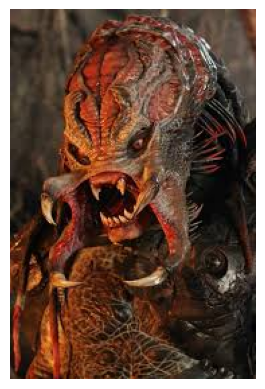

In [6]:
file = files[440]
img_color = iio.imread(file)
plt.axis('off')
plt.imshow(img_color)

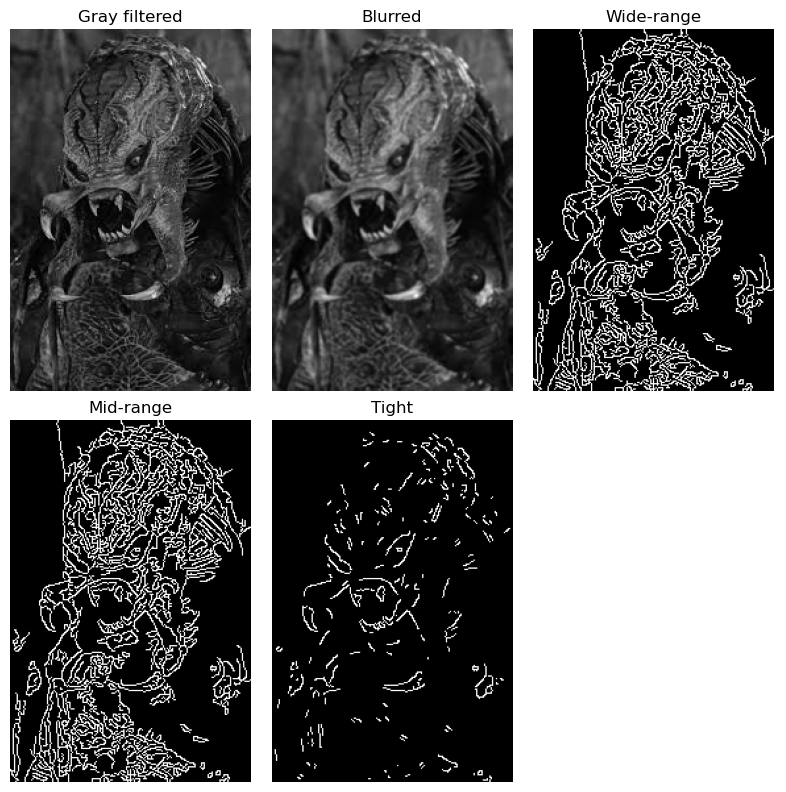

In [7]:
# Blur the image for better edge detection
blur = cv2.GaussianBlur(img_color, (3,3), 0) 
# Convert to graycsale
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
gray_noblur = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

# Using the Canny filter to get contours
# Using the Canny filter with different parameters
wide = cv2.Canny(gray, 50, 200)
mid = cv2.Canny(gray, 30, 150)
tight = cv2.Canny(gray, 210, 250)

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(gray_noblur, cmap=plt.cm.gray)
ax[0].set_title('Gray filtered')

ax[1].imshow(gray, cmap=plt.cm.gray)
ax[1].set_title('Blurred')

ax[2].imshow(wide, cmap=plt.cm.gray)
ax[2].set_title('Wide-range')

ax[3].imshow(wide, cmap=plt.cm.gray)
ax[3].set_title('Mid-range')

ax[4].imshow(tight, cmap=plt.cm.gray)
ax[4].set_title('Tight')


for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

In [8]:
def auto_canny_edge_detection(image, sigma=0.33):
    md = np.median(image)
    blur = cv2.GaussianBlur(image, (3,3), 0) 
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    lower_value = int(max(0, (1.0-sigma) * md))
    upper_value = int(min(255, (1.0+sigma) * md))
    return cv2.Canny(gray, lower_value, upper_value)

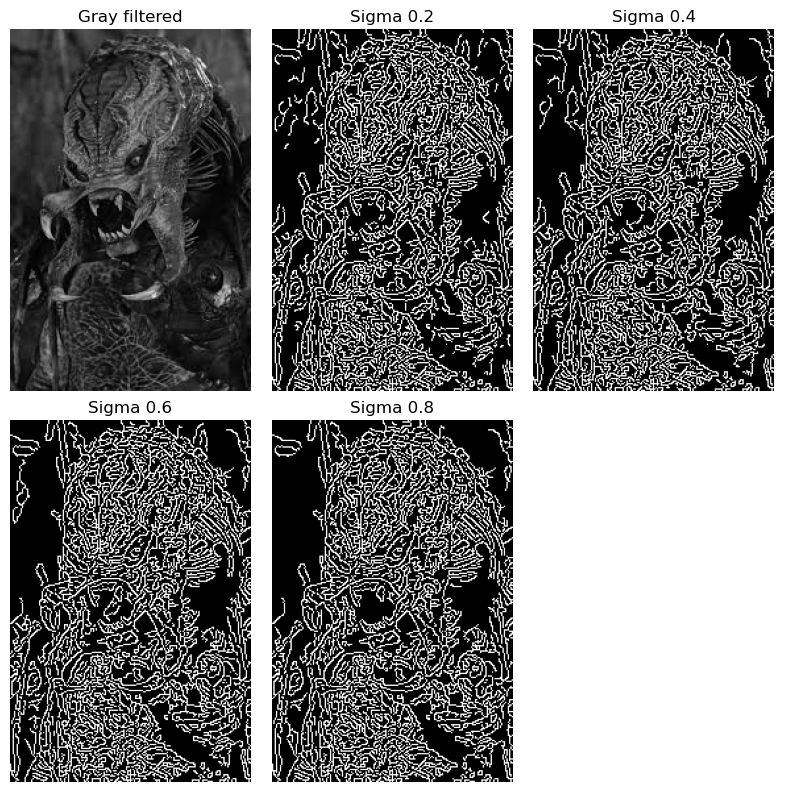

In [9]:
canny02 = auto_canny_edge_detection(img_color, 0.2)
canny04 = auto_canny_edge_detection(img_color, 0.4)
canny06 = auto_canny_edge_detection(img_color, 0.6)
canny08 = auto_canny_edge_detection(img_color, 0.8)

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(gray_noblur, cmap=plt.cm.gray)
ax[0].set_title('Gray filtered')

ax[1].imshow(canny02, cmap=plt.cm.gray)
ax[1].set_title('Sigma 0.2')

ax[2].imshow(canny04, cmap=plt.cm.gray)
ax[2].set_title('Sigma 0.4')

ax[3].imshow(canny06, cmap=plt.cm.gray)
ax[3].set_title('Sigma 0.6')

ax[4].imshow(canny08, cmap=plt.cm.gray)
ax[4].set_title('Sigma 0.8')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

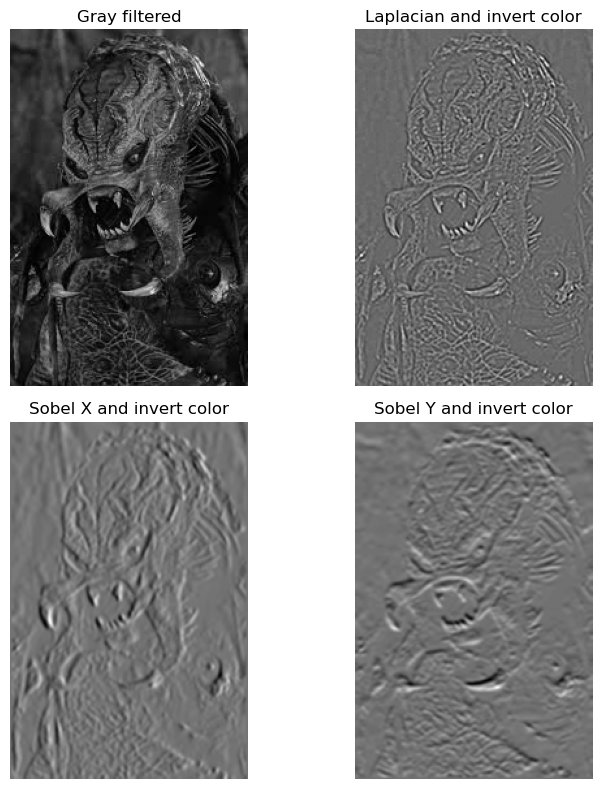

In [10]:
blur = cv2.GaussianBlur(img_color, (3,3), 0)
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
invert = cv2.bitwise_not(gray)

# convolute with proper kernels
laplacian = cv2.Laplacian(invert,cv2.CV_64F)
sobelx = cv2.Sobel(invert,cv2.CV_64F,1,0,ksize=5)  # x
sobely = cv2.Sobel(invert,cv2.CV_64F,0,1,ksize=5)  # y

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(gray_noblur, cmap=plt.cm.gray)
ax[0].set_title('Gray filtered')

ax[1].imshow(laplacian, cmap=plt.cm.gray)
ax[1].set_title('Laplacian and invert color')

ax[2].imshow(sobelx, cmap=plt.cm.gray)
ax[2].set_title('Sobel X and invert color')

ax[3].imshow(sobely, cmap=plt.cm.gray)
ax[3].set_title('Sobel Y and invert color')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

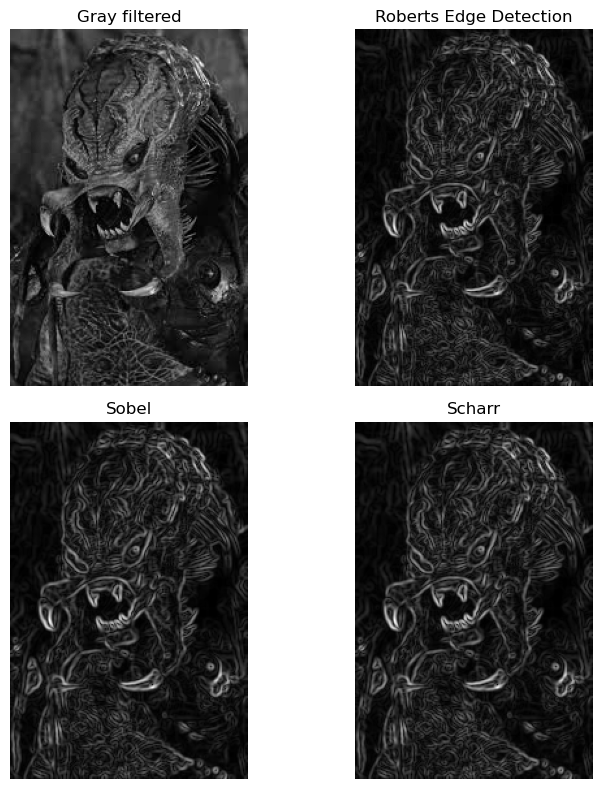

In [11]:
blur = cv2.GaussianBlur(img_color, (3,3), 0) 
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
edge_roberts = roberts(gray)
edge_sobel = sobel(gray)
edge_scharr = scharr(gray)
edge_prewitt = prewitt(gray)

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(gray_noblur, cmap=plt.cm.gray)
ax[0].set_title('Gray filtered')

ax[1].imshow(edge_roberts, cmap=plt.cm.gray)
ax[1].set_title('Roberts Edge Detection')

ax[2].imshow(edge_sobel, cmap=plt.cm.gray)
ax[2].set_title('Sobel')

ax[3].imshow(edge_scharr, cmap=plt.cm.gray)
ax[3].set_title('Scharr')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

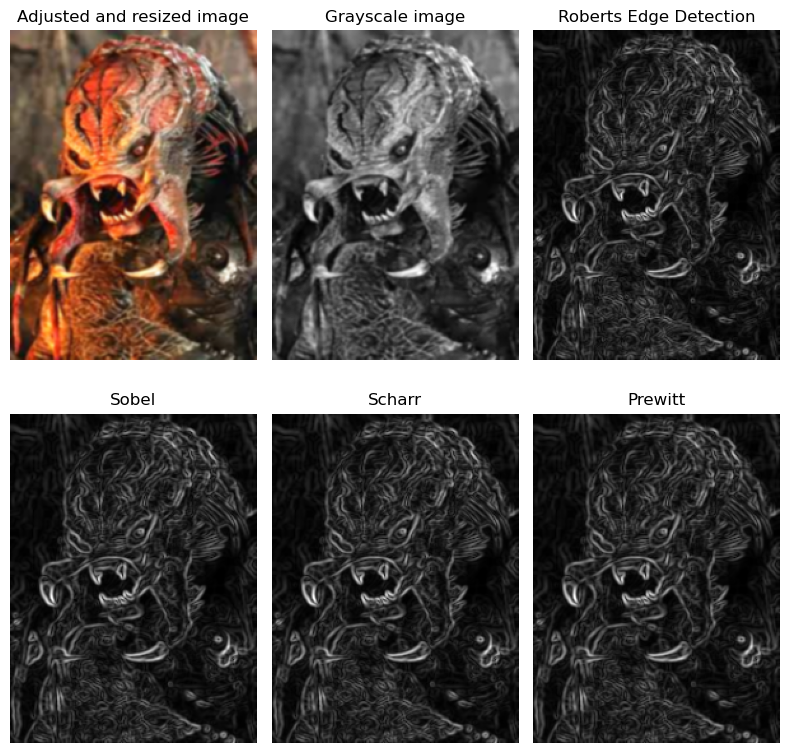

In [12]:
# create a black image
blank_bw = np.zeros((default_height, default_width), dtype = np.float32)

# resize image
width = default_width
height = default_height
dim = (width, height)
image = img_color

alpha = 1.5 # Contrast control (1.0-3.0)
beta = 0 # Brightness control (0-100)

adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
blur = cv2.GaussianBlur(adjusted, (3,3), 0) 
img_bw = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
edge_roberts = roberts(img_bw)
edge_sobel = sobel(img_bw)
edge_scharr = scharr(img_bw)
edge_prewitt = prewitt(img_bw)

resized = cv2.resize(blur, dim, interpolation = cv2.INTER_AREA)
img_bw = cv2.resize(img_bw, dim, interpolation = cv2.INTER_AREA)
edge_roberts = cv2.resize(edge_roberts, dim, interpolation = cv2.INTER_AREA)
edge_sobel = cv2.resize(edge_sobel, dim, interpolation = cv2.INTER_AREA)
edge_scharr = cv2.resize(edge_scharr, dim, interpolation = cv2.INTER_AREA)
edge_prewitt = cv2.resize(edge_prewitt, dim, interpolation = cv2.INTER_AREA)

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(resized)
ax[0].set_title('Adjusted and resized image')

ax[1].imshow(img_bw, cmap=plt.cm.gray)
ax[1].set_title('Grayscale image')

ax[2].imshow(edge_roberts, cmap=plt.cm.gray)
ax[2].set_title('Roberts Edge Detection')

ax[3].imshow(edge_sobel, cmap=plt.cm.gray)
ax[3].set_title('Sobel')

ax[4].imshow(edge_scharr, cmap=plt.cm.gray)
ax[4].set_title('Scharr')

ax[5].imshow(edge_prewitt, cmap=plt.cm.gray)
ax[5].set_title('Prewitt')


for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

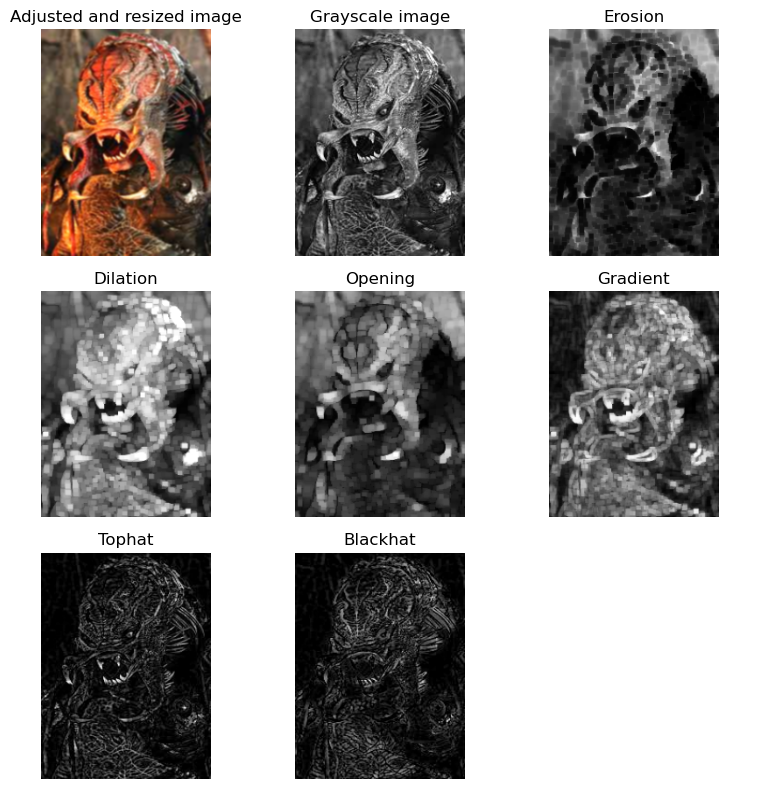

In [13]:
# create a black image
blank_bw = np.zeros((default_height, default_width), dtype = np.float32)

# resize image
width = default_width
height = default_height
dim = (width, height)
image = img_color

alpha = 1.5 # Contrast control (1.0-3.0)
beta = 0 # Brightness control (0-100)

adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
img_bw = cv2.cvtColor(adjusted, cv2.COLOR_BGR2GRAY)

kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(img_bw,kernel,iterations = 1)
dilation = cv2.dilate(img_bw,kernel,iterations = 1)
opening = cv2.morphologyEx(img_bw, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, kernel)
gradient = cv2.morphologyEx(img_bw, cv2.MORPH_GRADIENT, kernel)
tophat = cv2.morphologyEx(img_bw, cv2.MORPH_TOPHAT, kernel)
blackhat = cv2.morphologyEx(img_bw, cv2.MORPH_BLACKHAT, kernel)

resized = cv2.resize(blur, dim, interpolation = cv2.INTER_AREA)
img_bw = cv2.resize(img_bw, dim, interpolation = cv2.INTER_AREA)
erosion = cv2.resize(erosion, dim, interpolation = cv2.INTER_AREA)
dilation = cv2.resize(dilation, dim, interpolation = cv2.INTER_AREA)
opening = cv2.resize(opening, dim, interpolation = cv2.INTER_AREA)
closing = cv2.resize(closing, dim, interpolation = cv2.INTER_AREA)
gradient = cv2.resize(gradient, dim, interpolation = cv2.INTER_AREA)
tophat = cv2.resize(tophat, dim, interpolation = cv2.INTER_AREA)
blackhat = cv2.resize(blackhat, dim, interpolation = cv2.INTER_AREA)

fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(resized)
ax[0].set_title('Adjusted and resized image')

ax[1].imshow(img_bw, cmap=plt.cm.gray)
ax[1].set_title('Grayscale image')

ax[2].imshow(erosion, cmap=plt.cm.gray)
ax[2].set_title('Erosion')

ax[3].imshow(dilation, cmap=plt.cm.gray)
ax[3].set_title('Dilation')

ax[4].imshow(opening, cmap=plt.cm.gray)
ax[4].set_title('Opening')

ax[5].imshow(gradient, cmap=plt.cm.gray)
ax[5].set_title('Gradient')

ax[6].imshow(tophat, cmap=plt.cm.gray)
ax[6].set_title('Tophat')

ax[7].imshow(blackhat, cmap=plt.cm.gray)
ax[7].set_title('Blackhat')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

In [14]:
l1 = edge_roberts
l2 = tophat/255
l3 = blackhat/255

height = l1.shape[0]
width = l1.shape[1]

# create a black image
blank = np.zeros((default_height, default_width, 3), dtype = np.float32)
blank_img = np.zeros((default_height, default_width, 3), dtype = np.uint8)

for y in range(height):
    for x in range(width):
        p1 = l1[y, x]
        p2 = l2[y, x]
        p3 = l3[y, x]
        arrb = np.array([p1, p2, p3])
        arrim = np.array([p1, p2, p3]) * 255
        
        blank[y, x] = arrb
        blank_img[y, x] = arrim

(259, 194, 3)
(259, 194, 3)


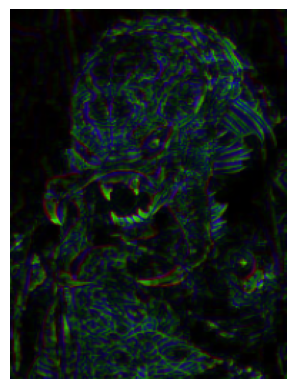

In [15]:
print(blank.shape)
print(blank_img.shape)

plt.axis('off')
plt.imshow(blank_img)

In [16]:
cwd = os.getcwd()
path = cwd + r'/work/alien-vs-predator/train'
files = listing_files(path, '*.jpg')

n_image = len(files)
width = default_width
height = default_height
dataset = np.zeros((n_image, height, width, 3), dtype = np.uint8)
labels = np.zeros((n_image, 1), dtype=np.float32)
files_shuffle = files.copy()
random.shuffle(files_shuffle)

pbar = tqdm(total = n_image)
for count, file in enumerate(files_shuffle):
    name = str(file.parent.name)
    dirname = file.parent
    im = iio.imread(file)

    if len(im.shape) < 3:
        color = 'b&w'
    else:
        color = 'color'
        
    # resize image
    width = default_width
    height = default_height
    dim = (width, height)
    image = im  

    alpha = 1.5 # Contrast control (1.0-3.0)
    beta = 0 # Brightness control (0-100)
    
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    blur = cv2.GaussianBlur(adjusted, (3,3), 0) 
    
    if color == 'color':
        img_bw = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
        img_bw_noblur = cv2.cvtColor(adjusted, cv2.COLOR_BGR2GRAY)
    else:
        img_bw = blur
        img_bw_noblur = adjusted
    
    edge_roberts = roberts(img_bw)
    
    kernel = np.ones((5,5),np.uint8)
    tophat = cv2.morphologyEx(img_bw_noblur, cv2.MORPH_TOPHAT, kernel)
    blackhat = cv2.morphologyEx(img_bw_noblur, cv2.MORPH_BLACKHAT, kernel)
    
    edge_roberts = cv2.resize(edge_roberts, dim, interpolation = cv2.INTER_AREA)
    tophat = cv2.resize(tophat, dim, interpolation = cv2.INTER_AREA)
    blackhat = cv2.resize(blackhat, dim, interpolation = cv2.INTER_AREA)
    
    l1 = edge_roberts * 255
    l2 = tophat
    l3 = blackhat

    height = l1.shape[0]
    width = l1.shape[1]

    # create a black image
    blank_img = np.zeros((default_height, default_width, 3), dtype = np.uint8)

    for y in range(height):
        for x in range(width):
            p1 = l1[y, x]
            p2 = l2[y, x]
            p3 = l3[y, x]
            arrim = np.array([p1, p2, p3])
            blank_img[y, x] = arrim

    dataset[count] = blank_img
    
    if name=='alien':
        labels[count, 0] = 0.0

    if name=='predator':
        labels[count, 0] = 1.0
    
    pbar.update(1)

pbar.close()

train_images = dataset
train_labels = labels

print(train_images.shape)
print(train_labels.shape)

100% 694/694 [00:40<00:00, 17.12it/s]

(694, 259, 194, 3)
(694, 1)


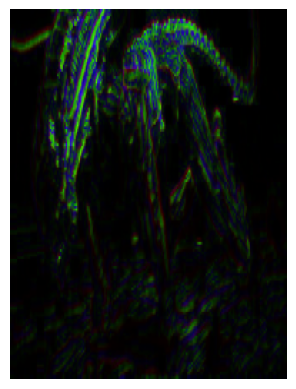

In [17]:
plt.axis('off')
plt.imshow(train_images[0])

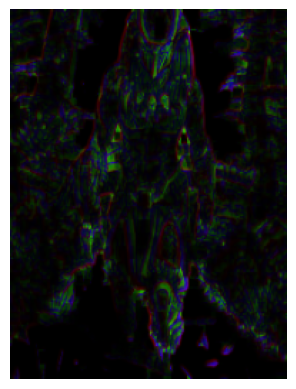

In [18]:
plt.axis('off')
plt.imshow(train_images[1])

In [19]:
cwd = os.getcwd()
path = cwd + r'/work/alien-vs-predator/validation'
files = listing_files(path, '*.jpg')

n_image = len(files)
width = default_width
height = default_height
dataset = np.zeros((n_image, height, width, 3), dtype = np.uint8)
labels = np.zeros((n_image, 1), dtype=np.float32)
files_shuffle = files.copy()
random.shuffle(files_shuffle)

pbar = tqdm(total = n_image)
for count, file in enumerate(files_shuffle):
    name = str(file.parent.name)
    dirname = file.parent
    im = iio.imread(file)

    if len(im.shape) < 3:
        color = 'b&w'
    else:
        color = 'color'
        
    # resize image
    width = default_width
    height = default_height
    dim = (width, height)
    image = im  

    alpha = 1.5 # Contrast control (1.0-3.0)
    beta = 0 # Brightness control (0-100)
    
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    blur = cv2.GaussianBlur(adjusted, (3,3), 0) 
    
    if color == 'color':
        img_bw = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
        img_bw_noblur = cv2.cvtColor(adjusted, cv2.COLOR_BGR2GRAY)
    else:
        img_bw = blur
        img_bw_noblur = adjusted
    
    edge_roberts = roberts(img_bw)
    
    kernel = np.ones((5,5),np.uint8)
    tophat = cv2.morphologyEx(img_bw_noblur, cv2.MORPH_TOPHAT, kernel)
    blackhat = cv2.morphologyEx(img_bw_noblur, cv2.MORPH_BLACKHAT, kernel)
    
    edge_roberts = cv2.resize(edge_roberts, dim, interpolation = cv2.INTER_AREA)
    tophat = cv2.resize(tophat, dim, interpolation = cv2.INTER_AREA)
    blackhat = cv2.resize(blackhat, dim, interpolation = cv2.INTER_AREA)
    
    l1 = edge_roberts * 255
    l2 = tophat
    l3 = blackhat

    height = l1.shape[0]
    width = l1.shape[1]

    # create a black image
    blank_img = np.zeros((default_height, default_width, 3), dtype = np.uint8)

    for y in range(height):
        for x in range(width):
            p1 = l1[y, x]
            p2 = l2[y, x]
            p3 = l3[y, x]
            arrim = np.array([p1, p2, p3])
            blank_img[y, x] = arrim

    dataset[count] = blank_img
    
    if name=='alien':
        labels[count, 0] = 0.0

    if name=='predator':
        labels[count, 0] = 1.0
    
    pbar.update(1)

pbar.close()

valid_images = dataset
valid_labels = labels

print(valid_images.shape)
print(valid_labels.shape)

100% 182/182 [00:10<00:00, 16.81it/s]

(182, 259, 194, 3)
(182, 1)


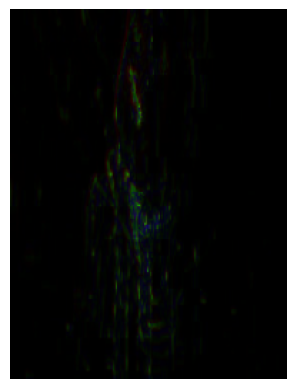

In [20]:
plt.axis('off')
plt.imshow(valid_images[0])

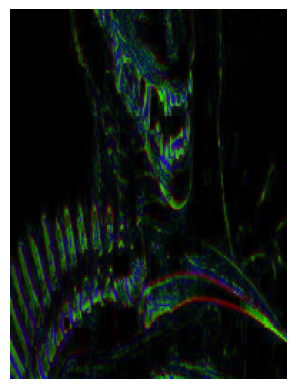

In [21]:
plt.axis('off')
plt.imshow(valid_images[1])

In [22]:
width = default_width
height = default_height
num_classes = 2
p = 16

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("vertical", input_shape=(height, width, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)

normalization_layer = layers.Rescaling(1./255)

model = models.Sequential([
  data_augmentation,
  normalization_layer,
  layers.Conv2D(p, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(2*p, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(4*p, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(8*p, activation='relu'),
  layers.Dense(num_classes,  activation='softmax', name="outputs")
])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 259, 194, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 259, 194, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 259, 194, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 129, 97, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 129, 97, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 48, 32)       0         
 2D)                                                  

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [25]:
batch_size = int(train_images.shape[0]/10)
workers = int(multiprocessing.cpu_count()/2)

In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 20, restore_best_weights=True)
history = model.fit(train_images, train_labels, epochs = 100, batch_size = batch_size, workers = workers, use_multiprocessing = True,
                    validation_data=(valid_images, valid_labels), callbacks=[callback])

Epoch 1/100
11/11 [==============================] - 7s 522ms/step - loss: 0.6960 - accuracy: 0.5130 - val_loss: 0.6802 - val_accuracy: 0.5934
Epoch 2/100
11/11 [==============================] - 6s 501ms/step - loss: 0.6812 - accuracy: 0.5749 - val_loss: 0.6693 - val_accuracy: 0.5824
Epoch 3/100
11/11 [==============================] - 6s 501ms/step - loss: 0.6725 - accuracy: 0.6182 - val_loss: 0.6553 - val_accuracy: 0.6044
Epoch 4/100
11/11 [==============================] - 6s 503ms/step - loss: 0.6476 - accuracy: 0.6470 - val_loss: 0.6589 - val_accuracy: 0.5989
Epoch 5/100
11/11 [==============================] - 6s 500ms/step - loss: 0.6441 - accuracy: 0.6354 - val_loss: 0.6810 - val_accuracy: 0.5879
Epoch 6/100
11/11 [==============================] - 6s 502ms/step - loss: 0.6595 - accuracy: 0.5951 - val_loss: 0.6551 - val_accuracy: 0.6209
Epoch 7/100
11/11 [==============================] - 6s 504ms/step - loss: 0.6536 - accuracy: 0.6268 - val_loss: 0.6337 - val_accuracy: 0.6484

11/11 [==============================] - 6s 502ms/step - loss: 0.5463 - accuracy: 0.7118 - val_loss: 0.6578 - val_accuracy: 0.6648
Epoch 42/100
11/11 [==============================] - 6s 500ms/step - loss: 0.5165 - accuracy: 0.7406 - val_loss: 0.7009 - val_accuracy: 0.6758
Epoch 43/100
11/11 [==============================] - 6s 502ms/step - loss: 0.5357 - accuracy: 0.7291 - val_loss: 0.5618 - val_accuracy: 0.7198
Epoch 44/100
11/11 [==============================] - 6s 502ms/step - loss: 0.5291 - accuracy: 0.7305 - val_loss: 0.5826 - val_accuracy: 0.7418
Epoch 45/100
11/11 [==============================] - 6s 500ms/step - loss: 0.5281 - accuracy: 0.7363 - val_loss: 0.6482 - val_accuracy: 0.6593
Epoch 46/100
11/11 [==============================] - 6s 501ms/step - loss: 0.5038 - accuracy: 0.7493 - val_loss: 0.7369 - val_accuracy: 0.6484
Epoch 47/100
11/11 [==============================] - 6s 501ms/step - loss: 0.5402 - accuracy: 0.7277 - val_loss: 0.6075 - val_accuracy: 0.6868
Epoch

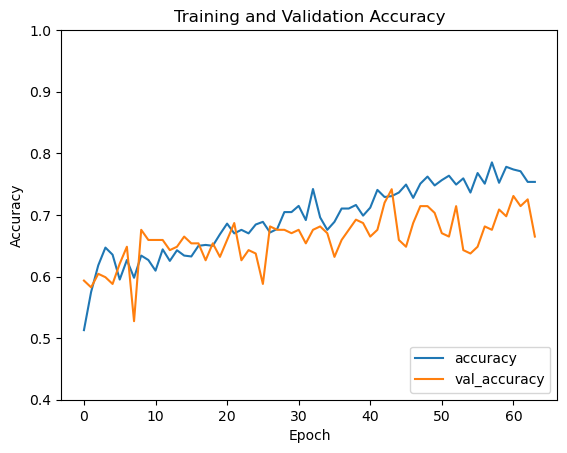

In [27]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1])
plt.legend(loc='lower right')

In [28]:
cwd = os.getcwd()
path = cwd + r'/work/alien-vs-predator/test'
files = listing_files(path, '*.jpg')

n_image = len(files)
width = default_width
height = default_height
dataset = np.zeros((n_image, height, width, 3), dtype = np.uint8)
labels = np.zeros((n_image, 1), dtype=np.float32)
files_shuffle = files.copy()
random.shuffle(files_shuffle)

pbar = tqdm(total = n_image)
for count, file in enumerate(files_shuffle):
    name = str(file.parent.name)
    dirname = file.parent
    im = iio.imread(file)

    if len(im.shape) < 3:
        color = 'b&w'
    else:
        color = 'color'
        
    # resize image
    width = default_width
    height = default_height
    dim = (width, height)
    image = im  

    alpha = 1.5 # Contrast control (1.0-3.0)
    beta = 0 # Brightness control (0-100)
    
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    blur = cv2.GaussianBlur(adjusted, (3,3), 0) 
    
    if color == 'color':
        img_bw = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
        img_bw_noblur = cv2.cvtColor(adjusted, cv2.COLOR_BGR2GRAY)
    else:
        img_bw = blur
        img_bw_noblur = adjusted
    
    edge_roberts = roberts(img_bw)
    
    kernel = np.ones((5,5),np.uint8)
    tophat = cv2.morphologyEx(img_bw_noblur, cv2.MORPH_TOPHAT, kernel)
    blackhat = cv2.morphologyEx(img_bw_noblur, cv2.MORPH_BLACKHAT, kernel)
    
    edge_roberts = cv2.resize(edge_roberts, dim, interpolation = cv2.INTER_AREA)
    tophat = cv2.resize(tophat, dim, interpolation = cv2.INTER_AREA)
    blackhat = cv2.resize(blackhat, dim, interpolation = cv2.INTER_AREA)
    
    l1 = edge_roberts * 255
    l2 = tophat
    l3 = blackhat

    height = l1.shape[0]
    width = l1.shape[1]

    # create a black image
    blank_img = np.zeros((default_height, default_width, 3), dtype = np.uint8)

    for y in range(height):
        for x in range(width):
            p1 = l1[y, x]
            p2 = l2[y, x]
            p3 = l3[y, x]
            arrim = np.array([p1, p2, p3])
            blank_img[y, x] = arrim

    dataset[count] = blank_img
    
    if name=='alien':
        labels[count, 0] = 0.0

    if name=='predator':
        labels[count, 0] = 1.0
    
    pbar.update(1)

pbar.close()

test_images = dataset
test_labels = labels

print(test_images.shape)
print(test_labels.shape)

100% 18/18 [00:01<00:00, 17.11it/s]

(18, 259, 194, 3)
(18, 1)


In [29]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

1/1 - 0s - loss: 0.3482 - accuracy: 0.9444 - 38ms/epoch - 38ms/step


In [30]:
predictions = model.predict(test_images)

1/1 [==============================] - 0s 76ms/step


In [31]:
predictions

array([[9.9893111e-01, 1.0689141e-03],
       [6.3611776e-01, 3.6388230e-01],
       [7.2183776e-01, 2.7816227e-01],
       [1.8689826e-01, 8.1310171e-01],
       [2.7892849e-01, 7.2107148e-01],
       [3.2055944e-01, 6.7944056e-01],
       [5.6859905e-01, 4.3140098e-01],
       [4.1750935e-01, 5.8249062e-01],
       [2.4151953e-01, 7.5848055e-01],
       [4.3453753e-01, 5.6546247e-01],
       [9.9985182e-01, 1.4820757e-04],
       [1.4775351e-01, 8.5224652e-01],
       [7.7046674e-01, 2.2953323e-01],
       [6.0361065e-02, 9.3963897e-01],
       [9.1678715e-01, 8.3212882e-02],
       [5.1917917e-01, 4.8082089e-01],
       [9.8084331e-02, 9.0191573e-01],
       [2.8647158e-01, 7.1352839e-01]], dtype=float32)

In [32]:
prediction_labels = np.argmax(predictions, axis=1)

In [33]:
prediction_labels

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1])

In [34]:
accuracy = round(accuracy_score(test_labels, prediction_labels), 4)
print('Accuracy: {}'.format(accuracy))

Accuracy: 0.9444


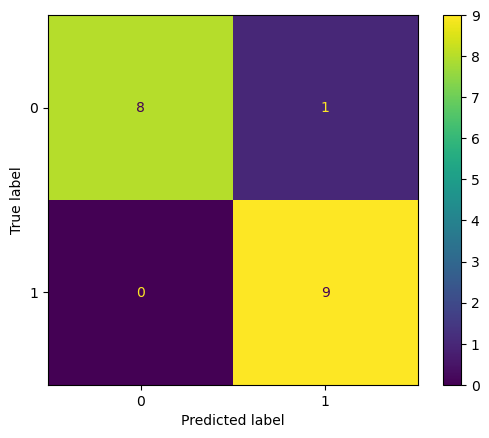

In [35]:
classes = list(set(prediction_labels))
cm = confusion_matrix(test_labels, prediction_labels, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()